<a href="https://colab.research.google.com/github/swetzel1/introduction_to_ml/blob/main/project/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physical Activity Monitoring


In [60]:
#load libraries

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import precision_score,recall_score, f1_score, confusion_matrix
from sklearn.decomposition   import PCA
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [2]:
folder_structure = '/content/drive/My Drive/Intro_to_ML/final_project/' #change this to your correspoding folder

file_names = ['subject101.dat',
              'subject102.dat',
              'subject103.dat',
              'subject104.dat',
              'subject105.dat',
              'subject106.dat',
              'subject107.dat',
              'subject108.dat',
              'subject109.dat' ]

In [3]:
file_names = [folder_structure + name for name in file_names ]

In [4]:
subject_id = [1,2,3,4,5,6,7,8,9]

activity_id_dict = {0: 'transient',
                    1: 'lying',
                    2: 'sitting',
                    3: 'standing',
                    4: 'walking',
                    5: 'running',
                    6: 'cycling',
                    7: 'Nordic_walking',
                    9: 'watching_TV',
                    10: 'computer_work',
                    11: 'car driving',
                    12: 'ascending_stairs',
                    13: 'descending_stairs',
                    16: 'vacuum_cleaning',
                    17: 'ironing',
                    18: 'folding_laundry',
                    19: 'house_cleaning',
                    20: 'playing_soccer',
                    24: 'rope_jumping' }

special_columns = ["timestamp", "activity_id","heartrate"]


imu_hand = ['hand_temperature',
            'hand_Acc6_1',       'hand_Acc6_2',        'hand_Acc6_3',
            'hand_Acc16_1',      'hand_Acc16_2',       'hand_Acc16_3',
            'hand_Gyro1',        'hand_Gyro2',         'hand_Gyro3',
            'hand_Magne1',       'hand_Magne2',        'hand_Magne3',
            'hand_Orientation1', 'hand_Orientation2',  'hand_Orientation3', 'hand_Orientation4']

imu_chest = ['chest_temperature',
             'chest_Acc16_1',       'chest_Acc16_2',      'chest_Acc16_3',
             'chest_Acc6_1',        'chest_Acc6_2',       'chest_Acc6_3',
             'chest_Gyro1',         'chest_Gyro2',        'chest_Gyro3',
             'chest_Magne1',        'chest_Magne2',       'chest_Magne3',
             'chest_Orientation1',  'chest_Orientation2', 'chest_Orientation3', 'chest_Orientation4']

imu_ankle = ['ankle_temperature',
           'ankle_Acc16_1',       'ankle_Acc16_2',      'ankle_Acc16_3',
           'ankle_Acc6_1',        'ankle_Acc6_2',       'ankle_Acc6_3',
           'ankle_Gyro1',         'ankle_Gyro2',        'ankle_Gyro3',
           'ankle_Magne1',        'ankle_Magne2',       'ankle_Magne3',
           'ankle_Orientation1',  'ankle_Orientation2', 'ankle_Orientation3', 'ankle_Orientation4']

columns = special_columns + imu_hand + imu_chest + imu_ankle  #put columns in one list

len(columns)

54

In [5]:
raw_data = pd.DataFrame()
for file in file_names:
    buffer = pd.read_table(file, header=None, sep='\s+')
    buffer.columns = columns #name columns
    buffer['subject_id'] = int(file[-5]) #add subject number to table (from filename)
    #dataCollection = dataCollection.append(procData, ignore_index=True) #does concat have anothery syntax than append?
    raw_data = pd.concat([raw_data, buffer], ignore_index=True)

raw_data.reset_index(drop=True, inplace=True)
raw_data.head()

,timestamp,activity_id,heartrate,hand_temperature,hand_Acc6_1,hand_Acc6_2,hand_Acc6_3,hand_Acc16_1,hand_Acc16_2,hand_Acc16_3,...,ankle_Gyro2,ankle_Gyro3,ankle_Magne1,ankle_Magne2,ankle_Magne3,ankle_Orientation1,ankle_Orientation2,ankle_Orientation3,ankle_Orientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1


## Data Cleaning

Additional files that come with the dataset explain how the data was gathered and give information on which parts of the data can be used.

* remove transient activity(id == 0), no usefull data
* remove columns 'Orientation' --> not used in information gathering
* remove columns 'accelerometer 6g' --> was not precicly calibrated during the data aquisition

* remove subject 9

* remove timestamp, since it doesnt contain any meaningful information correlated to the activity performed at the time

* remove subject id

* interpolate missing values due to:
  * different frequencies (heartrate sensor - 9Hz, IMUs 100Hz)
  * connection lost, package drops in wireless transmission



In [54]:
data = raw_data.drop(['hand_Orientation1',   'hand_Orientation2',  'hand_Orientation3',  'hand_Orientation4',
                      'chest_Orientation1',  'chest_Orientation2', 'chest_Orientation3', 'chest_Orientation4',
                      'ankle_Orientation1',  'ankle_Orientation2', 'ankle_Orientation3', 'ankle_Orientation4'],
                    axis = 1)  # removal of orientation columns

data = data.drop(['hand_Acc6_1',  'hand_Acc6_2',   'hand_Acc6_3',
                  'chest_Acc6_1', 'chest_Acc6_2',  'chest_Acc6_3',
                  'ankle_Acc6_1', 'ankle_Acc6_2',  'ankle_Acc6_3',],
                    axis = 1) # remove columns of accelerometer6g

data = data.drop(data[data.subject_id == 9].index) #(maybe not even load in first place ...)

In [55]:
#linear interpolation - think about other/better methods
data = data.interpolate() #interpolate before transient activity gets removed

In [56]:
data = data.drop(data[data.activity_id == 0].index) #remove any row of activity 0 (transient)

data = data.drop(['timestamp', 'subject_id'], axis = 1)

In [57]:
data.reset_index(drop = True, inplace = True)
data.head()

,activity_id,heartrate,hand_temperature,hand_Acc16_1,hand_Acc16_2,hand_Acc16_3,hand_Gyro1,hand_Gyro2,hand_Gyro3,hand_Magne1,...,ankle_temperature,ankle_Acc16_1,ankle_Acc16_2,ankle_Acc16_3,ankle_Gyro1,ankle_Gyro2,ankle_Gyro3,ankle_Magne1,ankle_Magne2,ankle_Magne3
0,1,100.0,30.375,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,8.93200,...,30.75,9.73855,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
1,1,100.0,30.375,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,9.58300,...,30.75,9.69762,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2,1,100.0,30.375,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,9.05516,...,30.75,9.69633,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119
3,1,100.0,30.375,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,9.92698,...,30.75,9.66370,-1.84714,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799
4,1,100.0,30.375,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,9.15626,...,30.75,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847


In [58]:
data.isnull().sum() #check for missing values left after interpolation

activity_id          0
heartrate            0
hand_temperature     0
hand_Acc16_1         0
hand_Acc16_2         0
hand_Acc16_3         0
hand_Gyro1           0
hand_Gyro2           0
hand_Gyro3           0
hand_Magne1          0
hand_Magne2          0
hand_Magne3          0
chest_temperature    0
chest_Acc16_1        0
chest_Acc16_2        0
chest_Acc16_3        0
chest_Gyro1          0
chest_Gyro2          0
chest_Gyro3          0
chest_Magne1         0
chest_Magne2         0
chest_Magne3         0
ankle_temperature    0
ankle_Acc16_1        0
ankle_Acc16_2        0
ankle_Acc16_3        0
ankle_Gyro1          0
ankle_Gyro2          0
ankle_Gyro3          0
ankle_Magne1         0
ankle_Magne2         0
ankle_Magne3         0
dtype: int64

## Visualization to understand the data better

<Axes: >

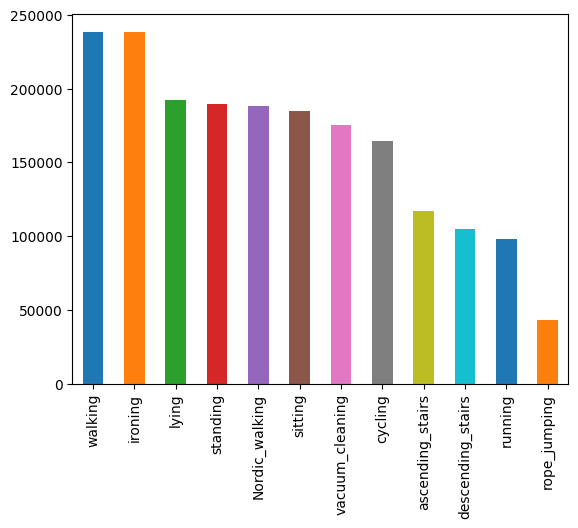

In [39]:
class_distribution = data['activity_id'].value_counts()

class_distribution.index = class_distribution.index.map(activity_id_dict)
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
class_distribution.plot(kind='bar', color=c)

In [40]:
data.describe()

,activity_id,heartrate,hand_temperature,hand_Acc16_1,hand_Acc16_2,hand_Acc16_3,hand_Gyro1,hand_Gyro2,hand_Gyro3,hand_Magne1,...,ankle_temperature,ankle_Acc16_1,ankle_Acc16_2,ankle_Acc16_3,ankle_Gyro1,ankle_Gyro2,ankle_Gyro3,ankle_Magne1,ankle_Magne2,ankle_Magne3
count,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,...,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06,1.936481e+06
mean,8.029295e+00,1.073525e+02,3.277667e+01,-4.899684e+00,3.555696e+00,3.803881e+00,4.251478e-04,3.967535e-02,-3.675619e-03,2.119165e+01,...,3.371950e+01,9.408030e+00,-1.579311e-01,-2.589932e+00,9.944300e-03,-3.661454e-02,6.633872e-03,-3.157416e+01,1.475657e+00,1.727037e+01
std,6.116767e+00,2.693154e+01,1.741638e+00,6.244352e+00,6.555389e+00,3.924271e+00,1.330247e+00,9.506782e-01,1.597039e+00,2.382032e+01,...,1.086185e+00,6.490730e+00,7.719233e+00,3.901461e+00,1.124367e+00,6.369318e-01,2.013201e+00,1.837041e+01,2.167065e+01,1.973404e+01
min,1.000000e+00,5.700000e+01,2.750000e+01,-6.121470e+01,-6.184170e+01,-6.193470e+01,-2.780440e+01,-1.339040e+01,-1.426470e+01,-1.039410e+02,...,3.000000e+01,-1.550680e+02,-1.574430e+02,-1.589260e+02,-2.399500e+01,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.027160e+02
25%,3.000000e+00,8.600000e+01,3.168750e+01,-8.872420e+00,1.061780e+00,1.375730e+00,-3.773260e-01,-2.228790e-01,-3.842260e-01,4.905620e+00,...,3.300000e+01,8.439360e+00,-2.171290e+00,-3.809910e+00,-2.073600e-01,-1.057730e-01,-4.401000e-01,-4.171790e+01,-1.230540e+01,3.735270e+00
50%,6.000000e+00,1.040000e+02,3.318750e+01,-5.397600e+00,3.564360e+00,3.673060e+00,-6.046260e-03,5.897600e-03,-5.677800e-03,2.304010e+01,...,3.406250e+01,9.538870e+00,-2.912660e-01,-2.419460e+00,4.603780e-03,-3.956140e-03,-2.349180e-03,-3.398440e+01,8.692470e-01,1.884630e+01
75%,1.300000e+01,1.240000e+02,3.406250e+01,-9.219740e-01,6.447600e+00,6.782080e+00,3.334210e-01,2.655670e-01,3.647670e-01,3.943580e+01,...,3.450000e+01,1.028920e+01,1.773260e+00,-1.047370e+00,1.297970e-01,1.153630e-01,9.041550e-02,-1.786890e+01,1.789680e+01,3.129140e+01
max,2.400000e+01,2.020000e+02,3.550000e+01,5.282140e+01,6.225980e+01,6.192340e+01,2.641580e+01,1.691710e+01,1.433840e+01,1.375440e+02,...,3.543750e+01,1.572320e+02,1.572930e+02,1.588720e+02,1.742040e+01,1.358820e+01,1.652880e+01,9.155160e+01,9.424780e+01,1.469000e+02


## Scale, Randomize, Split

In [69]:
#Scale
columns_to_scale = data.columns.drop('activity_id')

#Choose Scaling Approach

#scaler = MinMaxScaler()
scaler = StandardScaler()



# apply scaler
scaled_data = scaler.fit_transform(data[columns_to_scale])

In [72]:
#split 80/20
df_train, df_val = train_test_split(scaled_data, train_size = 0.8, test_size = 0.2, random_state = 100)
